# **Introduction to Quantum Computing (Lab 5 — Quantum Tic-Tac-Toe)**


In this lab you will an actual quantum game! Have fun 😀

In [ ]:
!pip install qiskit --quiet
!pip install pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install qiskit-aer --quiet # Install the missing module
from qiskit import *
from qiskit.visualization import plot_histogram
from google.colab import widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Button, Layout
import ipywidgets
import pandas as pd
import math
import numpy as np
import random
from IPython.display import clear_output
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 33.9 MB/s eta 0:00:00


The code for the game comprises the two classes below. Edit at your peril. But, also, edit if you want to change the rules of the game!

In [ ]:

class Board:
    def __init__(self):
        self.qc = QuantumCircuit(9, 9)
        self.function = ''
        self.target = -1
        self.tab = []
        self.winsX = 0
        self.winsO = 0

        for idx in range(0, 9):
            self.tab.append({'default':str(idx), 'player':' '})
            self.qc.reset(idx)
            self.qc.h(idx)
        self.qc.barrier()

    def make_move(self, cell):
        if self.function == 'Not':
            # add an $x$ gate
            self.tab[int(cell)]['player'] += 'N - '
        elif self.function == 'O':
            # add a rotation toward |0>
            self.tab[int(cell)]['player'] += "O - "
        elif self.function == 'X':
            # add a rotation toward |1>
            self.tab[int(cell)]['player'] += "X - "
        elif self.function == 'SWAP' and self.target != cell:
            if self.target == cell:
                self.target = -1
            else:
                # add a swap gate
                self.tab[int(cell)]['player'] += "S - "
                self.tab[int(self.target)]['player'] += "S - "

    def results(self):
        display(self.qc.draw('mpl'))
        self.qc = QuantumCircuit(9, 9)

    def display(self):
        display(self.qc.draw('mpl'))

    def measure(self):
        self.qc.barrier()
        for i in range(0,9):
            self.qc.measure(i, i)

        simulator = AerSimulator()
        job = simulator.run(self.qc, shots=1)
        counts = job.result().get_counts()
        output = list(counts.keys())[0]

       # output = job.result().get_memory()[0]

        for i in range(0,9):
            if output[9-1-i] == '0':
                self.tab[i]['player'] = 'X'
            else:
                self.tab[i]['player'] = 'O'
        self.winsX = self.countWinners('X')
        self.winsO = self.countWinners('O')

    def countWinners(self, player):
        winners = () #there are 8 triples (x,y,z) of win conditions... add them
        wins = 0
        for i in range(len(winners)):
            won = True
            for j in range(len(winners[0])):
                if not self.tab[winners[i][j]]['player'] == player:
                    won = False
            if won:
                wins = wins + 1
        return wins

    def new(self):
        self.tab.clear()
        for idx in range(0,9):
           self.tab.append({'default':str(idx), 'player':''})
           self.qc.reset(idx)
           self.qc.h(idx)
        self.qc.barrier()


In [ ]:
class Game:
    def __init__(self):
        self.selecting = False
        self.board = Board()
        self.boardbutton_list = []
        for i in range(0,9):
            button = Button(description=str(i))
            button.on_click(self.handle_game)
            self.boardbutton_list.append(button)

        self.funcbutton_list = []
        self.newButton('Measure')
        self.newButton('Not')
        self.newButton('O')
        self.newButton('X')
        self.newButton('SWAP')
        self.printmenu()
        self.printBoard()

    def newButton(self, name):
        function = Button(description=name, layout=Layout(width='86px', height='30px'))
        function.on_click(self.handle_game)
        self.funcbutton_list.append(function)

    def handle_game(self, b):
        try:
            if b.description == 'Measure':
                clear_output()
                self.replay()
                self.board.measure()
                self.scoreboard()
                self.printBoard()
                self.board.results()


            if b.description == 'Replay':
                clear_output()
                self.board.new()
                self.printmenu()
                self.printBoard()

            if int(b.description) >= 0:
                if self.selecting:
                    self.board.target = int(b.description)
                else:
                    clear_output()
                    self.printmenu()
                    self.board.make_move(int(b.description))
                    self.printBoard()
                    self.board.display()
            self.selecting = False
        except ValueError:
            self.board.function = b.description
            self.selecting = False
            if self.board.function == 'SWAP':
                self.selecting = True

    def printmenu(self):
        grid = widgets.Grid(1, 5)
        for (row, col) in grid:
            display(self.funcbutton_list[col])

    def scoreboard(self):
        print("X wins: " + str(self.board.winsX) + "    O wins: " + str(self.board.winsO))

    def replay(self):
        rep = Button(description="Replay")
        rep.on_click(self.handle_game)
        display(rep)

    def printBoard(self):
        grid = widgets.Grid(1, int(np.sqrt(9)), header_row=True, header_column=True)
        for row in range(int(np.sqrt(9))):
              for (useless, col) in grid:
                  print("\n"+self.board.tab[col + row * int(np.sqrt(9))]['player']+"\n")
                  display(self.boardbutton_list[col + row * int(np.sqrt(9))])

In this iteration, we'll play the game on the qiskit simulator.

## The game!
To make a move, click one of the 5 options above the board and then click the location where you want to make that move. To play "SWAP," you need to click two board locations.

Each move adds a gate to the game circuit. They do the following:

* **Measure** ends the round and execute the game circuit on the quantum device. The win conditions will be counted and displayed.
* **Not** flips an "owned" tile to the other player. If the tile is not currently owned, this does nothing.
* **O** turns the intial tile toward a tile owned by "O."
* **X** turns the intial tile toward a tile owned by "X."
* **SWAP** swaps the location of two tiles.

As you play, you will see the game circuit and the board. The board shows the sequence of moves, but is not 100% accurate. The game circuit is true state of the game.

Button(description='Replay', style=ButtonStyle())

X wins: 1    O wins: 1


,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


O



Button(description='0', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


O



Button(description='1', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


O



Button(description='2', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='3', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='4', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='5', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


O



Button(description='6', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='7', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='8', style=ButtonStyle())

<IPython.core.display.Javascript object>

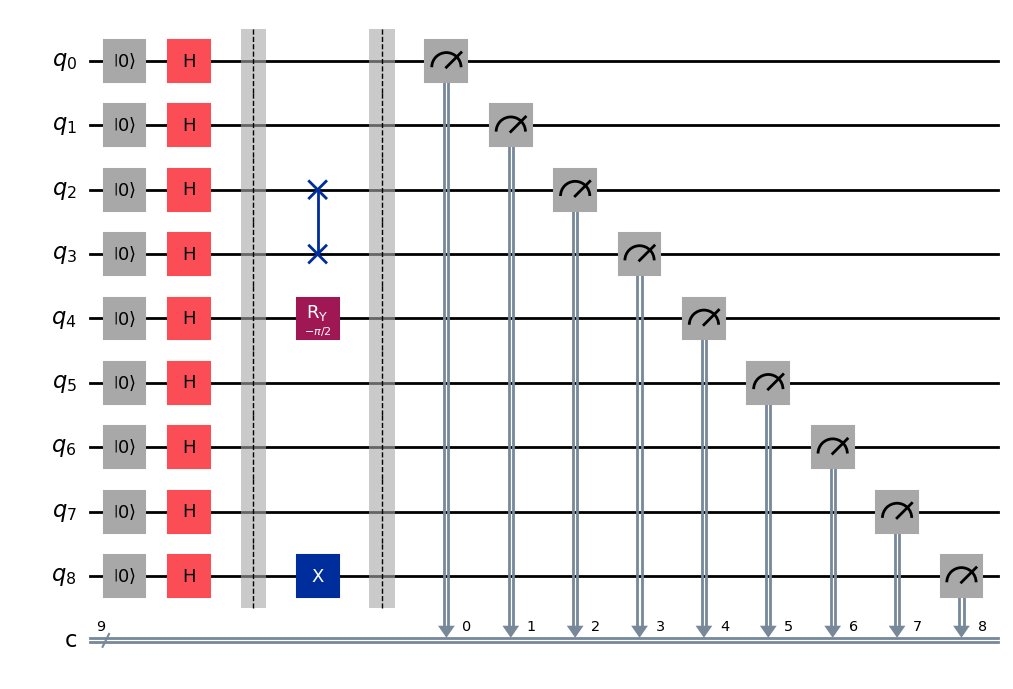

In [ ]:
game = Game()

In [ ]:
pip show pylatexenc


Name: pylatexenc
Version: 2.10
Summary: Simple LaTeX parser providing latex-to-unicode and unicode-to-latex conversion
Home-page: https://github.com/phfaist/pylatexenc
Author: Philippe Faist
Author-email: philippe.faist@bluewin.ch
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 
